In [1]:
%load_ext dotenv
%dotenv

In [22]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage, AIMessage
from typing import Literal

In [7]:
# defining the state
# Message state has a messages parameter which saves the messages in schema channel
# It has has reducer function defined => messages : Annoted(Sequence[BaseMessage], add_messages)
# Annoted provides constraints for the Sequence[BaseMessage]

class State(MessagesState):
    summary: str

In [50]:
chat = ChatOpenAI(
    model = "gpt-4o",
    seed = 365,
    temperature = 0,
    max_completion_tokens=100
)

In [45]:
graph = StateGraph(State)

In [19]:
def Node1(state: State) -> State:

    print("Entering node 1..............")
    print("Ask a question...")
    input_str = input()
    return State(summary = "", messages = [HumanMessage(input_str)])

In [44]:
# This is a chatbot and connects to the openai api

def Node2(state: State) -> State:

    summary = f"""
    Here is the summary of the conversation.
    {state.get('summary', "")}

    Keep this is mind while answering the questions and evaluating.
    """

    response = chat.invoke([SystemMessage(summary)] + state['messages'])

    response.pretty_print()

    return State(messages = [response])

In [35]:
# Asks the user for more questions

def Node3(state: State) -> State:

    q = "Would you like to ask another question?  (yes/no)"
    print(q)

    input_str = input()

    return State(messages = [AIMessage(q), HumanMessage(input_str)])

In [36]:
# Summarise all the messages
# Remove the old messages from the messsages list

def Node4(state: State) -> State:
    
    print("Trimming and summarising the messages before prompting the user to ask again.")

    new_conversation = ""

    for i in state['messages']:
        new_conversation += f"type: {i.type}, content: {i.content}"

    summary_instr = f"""
    Update the ongoing summary by incorporating the new lines of conversation below.  
    Build upon the previous summary rather than repeating it so that the result  
    reflects the most recent context and developments.

    Previous Summary:
    {state.get("summary", "")}

    New Conversation:
    {new_conversation}
    """

    removeMessages = [RemoveMessage(id = i.id) for i in state['messages']]

    # summarize the contents before saving the state
    summary = chat.invoke([HumanMessage(summary_instr)])

    return State(messages = removeMessages, summary = summary.content)


In [37]:
def routing_function(state: State) -> Literal["Node4", "__end__"]:
    
    if state["messages"][-1].content == "yes":
        return "Node4"
    else:
        return "__end__"

In [46]:
# Add the nodes

graph.add_node("Node1", Node1)
graph.add_node("Node2", Node2)
graph.add_node("Node3", Node3)
graph.add_node("Node4", Node4)


# Add the edges

graph.add_edge(START, "Node1")
graph.add_edge("Node1", "Node2")
graph.add_edge("Node2", "Node3")
graph.add_edge("Node4", "Node1")


# Adding conditional edge to node 3 as user can input or end the session

graph.add_conditional_edges(
    source = "Node3",
    path = routing_function
    )

In [47]:
graph_compiled = graph.compile()

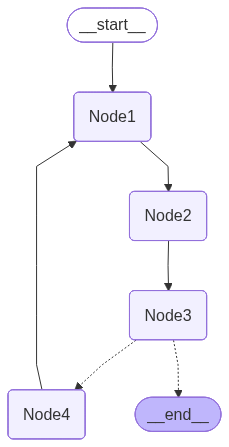

In [48]:
graph_compiled

In [51]:
graph_compiled.invoke(State(messages = []))

Entering node 1..............
Ask a question...
================================== Ai Message ==================================

AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. These systems can perform tasks that typically require human intelligence, such as understanding natural language, recognizing patterns, solving problems, and making decisions. AI can be categorized into narrow AI, which is designed for specific tasks, and general AI, which aims to perform any intellectual task that a human can do.
Would you like to ask another question?  (yes/no)
Trimming and summarising the messages before prompting the user to ask again.
Entering node 1..............
Ask a question...
================================== Ai Message ==================================

The concept of artificial intelligence (AI) began in the mid-20th century. The field was formally established in 1956 during a conferen

{'messages': [HumanMessage(content='When did AI start?', additional_kwargs={}, response_metadata={}, id='022f4507-ff3f-442d-95ed-33e47f1dbbda'),
  AIMessage(content='The concept of artificial intelligence (AI) began in the mid-20th century. The field was formally established in 1956 during a conference at Dartmouth College, where the term "artificial intelligence" was coined by John McCarthy. However, the ideas and foundations of AI can be traced back to earlier works by mathematicians and logicians like Alan Turing, who proposed the concept of a "universal machine" in the 1930s, which laid the groundwork for modern computing and', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 40, 'total_tokens': 140, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provide